In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pwd

/content


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/SW엔지니어

/content/drive/MyDrive/Colab Notebooks/SW엔지니어


In [6]:
!pwd

/content/drive/MyDrive/Colab Notebooks/SW엔지니어


### RNN 활용하기 : 네이버 영화 리뷰 데이터 감성분석

word 단위로 학습하기
- 데이터 로딩
- 결측치 제거
- 문제와 답 분리

In [7]:
# 데이터 로딩
import pandas as pd
train_df = pd.read_csv('./data/ratings_train.txt', delimiter = '\t')
test_df = pd.read_csv('./data/ratings_test.txt', delimiter = '\t')

In [8]:
train_df.info() # 결측치 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [10]:
# 결측치 제거
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


### 학습을 위한 전처리
- 특수문자 제거
- 불용어 제거
- 형태소 분리 (어간 추출 + 정규화)
- 인코딩(라벨인코딩 방식 활용) + 길이(순환 횟수) 맞추기

In [12]:
import re

In [13]:
# 특수문자 제거를 위한 정규표현식 패턴 설정
pattern = re.compile(r'[^a-zA-Z0-9가-힇\s\.\?\!]')
# \s : 공백문자 (스페이스, 탭, 줄바꿈 등)

In [14]:
example_review = "    오늘 영화 Review 평점은 10점 만점에 9.7!! 너무 재밌습니다~?!@@👍💰🥕 #꿀잼 #존잼 #감동쓰 "

In [15]:
# re.sub(정규 표현식, 문자열, 바꿀 대상 문자열)
re.sub(pattern, "", example_review)

'    오늘 영화 Review 평점은 10점 만점에 9.7!! 너무 재밌습니다?! 꿀잼 존잼 감동쓰 '

In [16]:
!pip -q install konlpy kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 45.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 23.2 MB/s eta 0:00:00


In [17]:
from kiwipiepy.utils import Stopwords
# 불용어 : 자주 등장하지만 분석에 큰 의미가 없는 단어들

In [18]:
stopwords = Stopwords()

In [19]:
# 등록되어 있는 불용어 확인
print( stopwords.stopwords )

{('성', 'XSN'), ('그', 'NP'), ('같', 'VA'), ('어야', 'EC'), ('일', 'NNG'), ('한', 'MM'), ('ᆫ', 'ETM'), ('것', 'NNB'), ('은', 'ETM'), ('지', 'EC'), ('따르', 'VV'), ('되', 'VV'), ('에서', 'JKB'), ('받', 'VV'), ('지', 'VX'), ('명', 'NNB'), ('하', 'VV'), ('부터', 'JX'), ('만', 'NR'), ('다', 'EF'), ('과', 'JC'), ('있', 'VX'), ('화', 'XSN'), ('까지', 'JX'), ('이', 'JKC'), ('년', 'NNB'), ('말', 'NNG'), ('없', 'VA'), ('보', 'VV'), ('때문', 'NNB'), ('고', 'JKQ'), ('면', 'EC'), ('주', 'VX'), ('고', 'EC'), ('게', 'EC'), ('와', 'JC'), ('적', 'XSN'), ('되', 'XSV'), ('과', 'JKB'), ('더', 'MAG'), ('을', 'JKO'), ('않', 'VX'), ('하', 'XSV'), ('다는', 'ETM'), ('으로', 'JKB'), ('다', 'EC'), ('이', 'MM'), ('등', 'NNB'), ('기', 'ETN'), ('지역', 'NNG'), ('은', 'JX'), ('ᆫ', 'JX'), ('수', 'NNB'), ('를', 'JKO'), ('라는', 'ETM'), ('와', 'JKB'), ('ᆫ다', 'EF'), ('일', 'NNB'), ('는', 'ETM'), ('ᆯ', 'ETM'), ('하', 'VX'), ('면서', 'EC'), ('어', 'EF'), ('사람', 'NNG'), ('때', 'NNG'), ('제', 'XPN'), ('다고', 'EC'), ('을', 'ETM'), ('이', 'NP'), ('가', 'JKS'), ('의', 'JKG'), ('월', 'NNB'), ('에', 'JKB'

In [20]:
# 한 줄 for문
stopwords_list = [ word for word, tag in stopwords.stopwords ]

# 여러 줄 for문
# stopwords_list = []
# for word, tag in stopwords.stopwords:
#   stopwords_list.append(word)

In [21]:
print(stopwords_list)

['성', '그', '같', '어야', '일', '한', 'ᆫ', '것', '은', '지', '따르', '되', '에서', '받', '지', '명', '하', '부터', '만', '다', '과', '있', '화', '까지', '이', '년', '말', '없', '보', '때문', '고', '면', '주', '고', '게', '와', '적', '되', '과', '더', '을', '않', '하', '다는', '으로', '다', '이', '등', '기', '지역', '은', 'ᆫ', '수', '를', '라는', '와', 'ᆫ다', '일', '는', 'ᆯ', '하', '면서', '어', '사람', '때', '제', '다고', '을', '이', '가', '의', '월', '에', '어서', '었', '원', '나', '통하', '라', '겠', '있', '하', '위하', '들', '중', '그', '만', '도', '어', '며', '던', '이', '이', '지만', '우리', '는', '로', '아니', '대하', '에게']


In [22]:
from konlpy.tag import Okt

In [23]:
okt = Okt()

In [24]:
# 품사 태깅(pos tagging) 예시
temp = okt.pos(
    '이런것도된다곸ㅋㅋㅋㅋㅋㅋㅋ',
    stem = True, # 어간 추출 (먹었다, 먹었음, 먹었어요 → '먹다' )
    norm = True, # 정규화 (입력 문장을 표준화 된 형태소로 변환하거나 비표준표현 삭제)
)
temp

[('이런', 'Modifier'),
 ('것', 'Noun'),
 ('도', 'Josa'),
 ('되다', 'Verb'),
 ('ㅋㅋㅋ', 'KoreanParticle')]

In [25]:
okt.tagset
# Noun(명사), Adjective(형용사), Verb(동사) 선택

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [26]:
# 전처리 함수 정의
def preprocess_text(text):
  # 1. 특수문자 제거, 소문자 변환, 양쪽 끝 공백 제거
  text = re.sub(pattern, "", text).lower().strip()

  # 2. 형태소 분석 (어간 추출/정규화)
  pos_tags = okt.pos(text, stem=True, norm=True)

  # 3. 명사, 형용사, 동사만 남기고, kiwipiepy의 stopwords에 있는 불용어는 필터링
  tokens = [
    word
    for word, tag in pos_tags
    if tag in ['Noun', 'Verb', 'Adjective'] and word not in stopwords_list
  ]
  return " ".join(tokens) # 공백으로 이어서 문자열로 반환

In [27]:
"   Star B ucks   ".lower().strip()

'star b ucks'

In [28]:
from tqdm.auto import tqdm

In [29]:
tqdm.pandas()

In [28]:
X_train_clean = train_df['document'].progress_apply(preprocess_text)
X_test_clean = test_df['document'].progress_apply(preprocess_text)

  0%|          | 0/149995 [00:00<?, ?it/s]

  0%|          | 0/49997 [00:00<?, ?it/s]

In [42]:
X_train_clean.shape, X_test_clean.shape

((149995,), (49997,))

In [43]:
X_train_clean.head()

,document
0,더빙 진짜 짜증나다 목소리
1,흠 포스터 보고 초딩 영화 줄 오버 연기 가볍다 않다
2,무재 밓었 다그 래서 보다 추천
3,교도소 이야기 구먼 솔직 재미 없다 평점 조정
4,몬페 익살스럽다 연기 돋보이다 영화 스파이더맨 늙다 보이다 하다 커스틴 던스트 이쁘...


In [31]:
# label 분리
y_train = train_df['label']
y_test = test_df['label']

In [32]:
y_train.shape, y_test.shape

((149995,), (49997,))

# 전처리 완료된 데이터 저장

In [30]:
import pickle

In [34]:
# 저장
with open('./data/X_train_mophs.pkl', 'wb') as f:
  pickle.dump(X_train_clean, f)
with open('./data/X_test_mophs.pkl', 'wb') as f:
  pickle.dump(X_test_clean, f)

with open('./data/y_train_mophs.pkl', 'wb') as f:
  pickle.dump(y_train, f)
with open('./data/y_test_mophs.pkl', 'wb') as f:
  pickle.dump(y_test, f)

# 데이터 로딩

In [31]:
# 로딩
with open('./data/X_train_mophs.pkl', 'rb') as f:
  X_train_clean = pickle.load(f)
with open('./data/X_test_mophs.pkl', 'rb') as f:
  X_test_clean = pickle.load(f)

with open('./data/y_train_mophs.pkl', 'rb') as f:
  y_train = pickle.load(f)
with open('./data/y_test_mophs.pkl', 'rb') as f:
  y_test = pickle.load(f)

In [32]:
X_train_clean.head(2)

,document
0,더빙 진짜 짜증나다 목소리
1,흠 포스터 보고 초딩 영화 줄 오버 연기 가볍다 않다


In [33]:
y_train.shape, y_test.shape

((149995,), (49997,))

# 시퀀스 변환 준비
> 토큰화 : 문장을 특정 기준에 맞춰 쪼개는 것
> - 글자단위, 단어단위(띄어쓰기), 형태소단위(명사,형용사,동사 등)

> 수치화(벡터화) : 잘라진 토큰을 일정 기준(알고리즘)에 맞춰 숫자로 변경하는 것
> - 빈도인코딩, 원핫인코딩, 라벨인코딩, BOW, Tf-idf 등


In [34]:
from tensorflow.keras.layers import TextVectorization
# 텍스트 데이터를 토큰화, 수치화로 학습용 데이터로 변경하는 클래스

In [35]:
vectorizer = TextVectorization(
    # 사전에서 사용할 최대 단어 수 설정
    max_tokens = 5000,

    # 텍스트를 어떻게 변환할지 지정하는 옵션
    output_mode = 'int', # -> 텍스트를 정수 인덱스로 변환하여 각 단어에 해당하는 정수 출력

    # 텍스트 데이터를 표준화하는 방식 (텍스트가 일관된 형식으로 정리됨)
    standardize = 'lower_and_strip_punctuation', # 모두 소문자 변환, 구두점 제거

    # 출력되는 정수 시퀀스의 길이 고정 (짧으면 패딩(0)으로 채움, 길면 자름)
    output_sequence_length = 10,
)

In [36]:
# 훈련데이터 기반으로 전처리, 토큰화, 단어사전 구축 실시
vectorizer.adapt(X_train_clean)

In [37]:
# 단어사전의 수 확인
vectorizer.vocabulary_size()

5000

In [38]:
# 단어토큰 확인
print(vectorizer.get_vocabulary())
# UNK : 단어사전에 등록되지 않은 단어를 표현하는 토큰 (unknown 토큰)

['', '[UNK]', np.str_('영화'), np.str_('하다'), np.str_('보다'), np.str_('없다'), np.str_('있다'), np.str_('좋다'), np.str_('재밌다'), np.str_('정말'), np.str_('되다'), np.str_('진짜'), np.str_('같다'), np.str_('이다'), np.str_('점'), np.str_('아니다'), np.str_('않다'), np.str_('만들다'), np.str_('나오다'), np.str_('연기'), np.str_('평점'), np.str_('최고'), np.str_('왜'), np.str_('스토리'), np.str_('생각'), np.str_('드라마'), np.str_('감동'), np.str_('보고'), np.str_('아깝다'), np.str_('이렇다'), np.str_('배우'), np.str_('내'), np.str_('재미있다'), np.str_('거'), np.str_('감독'), np.str_('뭐'), np.str_('들다'), np.str_('재미'), np.str_('내용'), np.str_('그냥'), np.str_('주다'), np.str_('재미없다'), np.str_('좀'), np.str_('자다'), np.str_('지루하다'), np.str_('쓰레기'), np.str_('시간'), np.str_('가다'), np.str_('모르다'), np.str_('그렇다'), np.str_('싶다'), np.str_('작품'), np.str_('알다'), np.str_('사랑'), np.str_('오다'), np.str_('하나'), np.str_('다시'), np.str_('볼'), np.str_('마지막'), np.str_('완전'), np.str_('처음'), np.str_('정도'), np.str_('많다'), np.str_('장면'), np.str_('액션'), np.str_('주인공'), np.str_('차다'),

In [39]:
# 학습 데이터를 벡터화하여 정수 시퀀스로 변환
X_train_vec = vectorizer(X_train_clean)
X_test_vec = vectorizer(X_test_clean)

In [40]:
X_train_vec.shape
# (데이터 수, 시퀀스 길이(순환 횟수))

TensorShape([149995, 10])

In [41]:
X_train_clean[0]

'더빙 진짜 짜증나다 목소리'

In [42]:
X_train_vec[0]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([341,  11, 161, 503,   0,   0,   0,   0,   0,   0])>

In [43]:
X_train_vec.shape

TensorShape([149995, 10])

In [44]:
# test 데이터 변경
X_test_vec = vectorizer(X_test_clean)
X_test_vec.shape

TensorShape([49997, 10])

In [45]:
import numpy as np

In [46]:
# X_train의 입력 데이터 shape를 (14995, 10, 1)로 변환 후 학습 필요
X_train_vec = np.expand_dims(X_train_vec, -1) # 1- : 마지막 축(axis)에 새로운 차원 추가
X_test_vec = np.expand_dims(X_test_vec, -1) # (49997, 10, 1)

In [47]:
# 최종 모양 확인
X_train_vec.shape, X_test_vec.shape

# X_train_vec
# 약 15만개의 리뷰 데이터, 10개의 시퀀스 길이(순환 횟수), 벡터는 1개의 특성(정수 인덱스)

((149995, 10, 1), (49997, 10, 1))

# 학습

1. 모델 구조 정의
2. 학습방법 설정
3. 학습
4. 예측

In [48]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, SimpleRNN

In [49]:
# 1. 모델 구조 정의
model = Sequential()

model.add(InputLayer(shape=(10,1))) # 입력층
model.add(SimpleRNN(units=64))
model.add(Dense(units=1, activation='sigmoid')) # 출력층 (이진분류 - 긍/부정)
# 이진분류

In [50]:
# 2. 학습방법 설정
model.compile(
    loss = 'binary_crossentropy', # 이진분류
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [51]:
# 3. 모델 학습
his_rnn = model.fit(
    X_train_vec, y_train, epochs = 40,
    batch_size = 128, validation_split = 0.2,
)

Epoch 1/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5229 - loss: 0.6920 - val_accuracy: 0.5335 - val_loss: 0.6859
Epoch 2/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5358 - loss: 0.6851 - val_accuracy: 0.5386 - val_loss: 0.6818
Epoch 3/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5371 - loss: 0.6806 - val_accuracy: 0.5427 - val_loss: 0.6784
Epoch 4/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5397 - loss: 0.6788 - val_accuracy: 0.5436 - val_loss: 0.6782
Epoch 5/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5400 - loss: 0.6771 - val_accuracy: 0.5421 - val_loss: 0.6769
Epoch 6/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5467 - loss: 0.6753 - val_accuracy: 0.5445 - val_loss: 0.6751
Epoch 7/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5442 - loss: 0.6741 - val_accuracy: 0.5444 - val_loss: 0.6757
Epoch 8/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5478 - loss: 0.6715 - val_accuracy: 

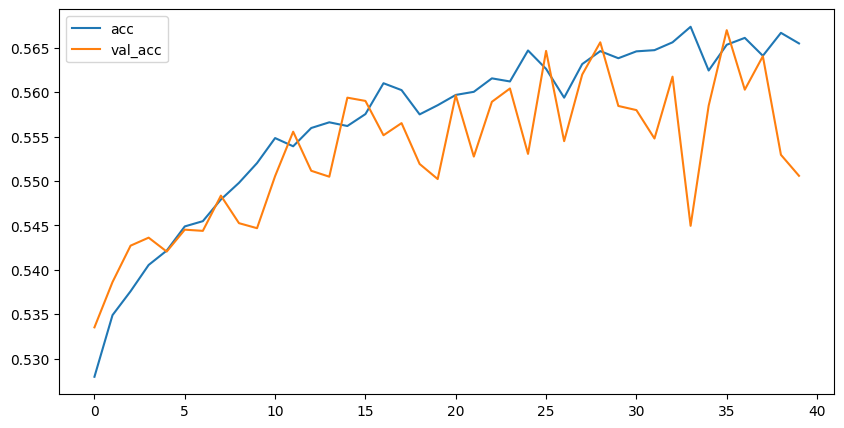

In [52]:
# 학습 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(his_rnn.history['accuracy'], label='acc')
plt.plot(his_rnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [53]:
# 4. 예측
pred = model.predict(X_test_vec)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [54]:
# 이진분류
pred_cls = ( pred > 0.5 ).astype('int')
pred_cls

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [55]:
y_test_sample = y_test.copy()

In [56]:
y_test_sample = pd.DataFrame(y_test_sample) # 시리즈 -> 2차원 df로 만든 후

In [57]:
y_test_sample['rnn_pred_cls'] = pred_cls # 컬럼 추가

In [58]:
y_test_sample # 실제 답, rnn이 예측한 클래스 값

,label,rnn_pred_cls
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
49995,1,0
49996,0,1
49997,0,0
49998,0,1


In [59]:
# 모델 평가
model.evaluate(X_test_vec, y_test)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5537 - loss: 0.6606


[0.6619676351547241, 0.553033173084259]

# SimpleRNN(바닐라RNN)의 경우 긴 시퀀스를 가진 데이터를 효과적으로 학습하기 어려움
- 순환횟수(시퀀스)가 길어질수록 초반에 입력된 단어의 기억데이터가 소실되는 기울기 소실 현상이 발생함
- 문장 구성 시 초반 단어가 후반 예측에 영향을 주는 경우 바닐라RNN이 학습하기 어려움